In [41]:
import optuna
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from pathlib import Path

In [20]:
models = ["logistic", "xgboost"]

In [54]:
def suffix_func(name):
    if "liltab" in name:
        return "liltab"
    if "d2v_warmstart" in name:
        return "d2v"
    if "rank" in name:
        return "rank"
    return "baseline"

In [55]:
# sufix_func = lambda name: 'liltab' if 'liltab' in name else ('d2v' if 'd2v_warmstart' in name else 'baseline')
def model_name_func(name):
    for model in models:
        if model in name:
            return model
        
name_re = re.compile('(.*-[0-9]+)_')

In [64]:
res = optuna.get_all_study_summaries(f"sqlite:///results/warmstart_dbs/uci/uci_fold_0.db")

In [76]:
def generate_plot_df(study_path):
    res = optuna.get_all_study_summaries(f"sqlite:///{study_path}")
    study_full_names = list(map(lambda study: study.study_name, res))
    study_methods = list(map(lambda name: suffix_func(name), study_full_names))
    study_models = list(map(lambda name: model_name_func(name), study_full_names))
    study_names = list(map(lambda m: re.split(r"_logistic|_xgboost", m)[0], study_full_names))

    p_bar = tqdm(
        (zip(study_names, study_methods, study_models, study_full_names)), total=len(study_names)
    )

    df = pd.DataFrame()

    for name, method, model, full_name in p_bar:
        study = optuna.load_study(study_name=full_name, storage=f"sqlite:///{study_path}")

        study_scores = list(map(lambda trail: trail.value, study.trials))
        study_scores_best = list(np.maximum.accumulate(study_scores))
        study_number = list(map(lambda trail: trail.number, study.trials))
        n = len(study_number)

        new_record = pd.DataFrame(
            {
                "score": study_scores_best,
                "no": study_number,
                "method": [method for _ in range(n)],
                "model": [model for _ in range(n)],
                "name": [name for _ in range(n)],
            }
        )
        df = pd.concat([df, new_record])
    return df

In [144]:
paths = list(Path("results/warmstart_dbs/uci").iterdir())

In [145]:
plot_dfs = list(map(generate_plot_df, tqdm(paths)))

100%|██████████| 5/5 [02:16<00:00, 27.29s/it]


In [146]:
for i, d in enumerate(plot_dfs):
    d["fold"] = i

In [147]:
df = pd.concat(plot_dfs, axis=0)

In [148]:
df

,score,no,method,model,name,fold
0,0.750000,0,rank,logistic,pittsburg-bridges-TYPE,0
1,0.750000,1,rank,logistic,pittsburg-bridges-TYPE,0
2,0.750000,2,rank,logistic,pittsburg-bridges-TYPE,0
3,0.750000,3,rank,logistic,pittsburg-bridges-TYPE,0
4,0.750000,4,rank,logistic,pittsburg-bridges-TYPE,0
...,...,...,...,...,...,...
25,0.955495,25,liltab,xgboost,ionosphere,4
26,0.955495,26,liltab,xgboost,ionosphere,4
27,0.955495,27,liltab,xgboost,ionosphere,4
28,0.955495,28,liltab,xgboost,ionosphere,4


## Count of tasks when method is best in i-th iteration

In [149]:
df_grouped = df.sort_values("score").groupby(["fold", "name", "model", "no"]).last().reset_index()
results = df_grouped.groupby(["fold", "no", "model", "method"]).count().reset_index()

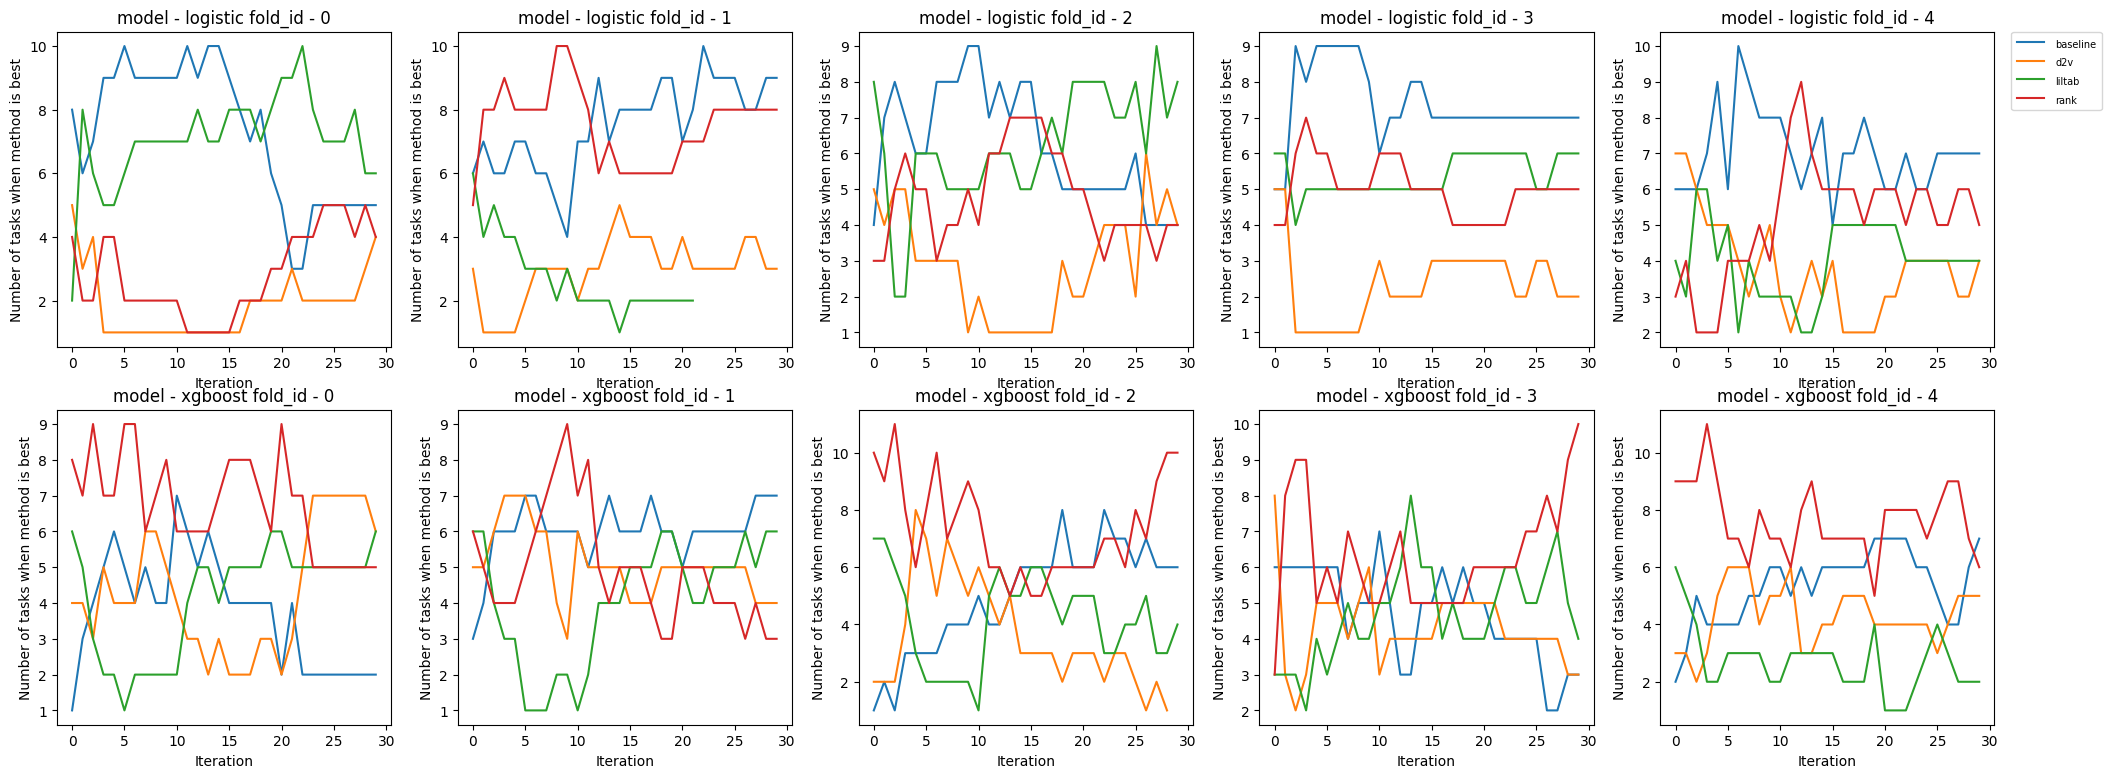

In [150]:
models = ["logistic", "xgboost"]
fold_ids = list(range(5))

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(25, 9))

for i, model in enumerate(models):
    for j, fold in enumerate(fold_ids):
        p = sns.lineplot(
            results[(results["model"] == model) & (results["fold"] == fold)].sort_values("method"),
            x="no",
            y="score",
            hue="method",
            ax=ax[i][j],
        )
        p.set_ylabel("Number of tasks when method is best")
        p.set_xlabel("Iteration")
        p.set_title(f"model - {model} fold_id - {fold}")
        if i == 0 and j == len(fold_ids) - 1:
            p.legend(loc=(1.05, .75))
            plt.setp(p.get_legend().get_title(), fontsize=7)
            plt.setp(p.get_legend().get_texts(), fontsize=7)
        else:
            p.legend([], [], frameon=False)


## Average rank in i-th iteration

In [18]:
ranks = df.groupby(['run_id', 'name', 'model', 'no'])['score'].rank('average', ascending=False)
df_copy = df.copy()
df_copy['rank'] = ranks

rank_df = df_copy.groupby(['run_id', 'no', 'model', 'method']).mean('rank').reset_index()

Text(0.5, 1.0, 'Average rank in i-th iteration')

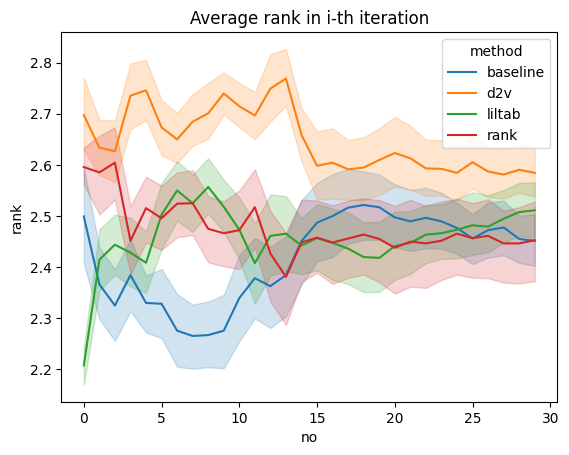

In [19]:
sns.lineplot(rank_df[rank_df["model"] == "logistic"], x="no", y="rank", hue="method").set_title(
    "Average rank in i-th iteration"
)

## ADTM

In [153]:
scores_min_max = (
    df.groupby(["fold", "name", "model"], as_index=False)
    .agg({"score": ["min", "max"]})
    .reset_index(drop=False)
)
scores_min_max.columns = scores_min_max.columns.get_level_values(0)
scores_min_max.columns = scores_min_max.columns[:-2].tolist() + ["min", "max"]

df_with_min_max = df.merge(scores_min_max, how="left", on=["fold", "name", "model"])
df_with_min_max["score"] = (df_with_min_max["score"] - df_with_min_max["min"]) / (
    df_with_min_max["max"] - df_with_min_max["min"]
)
df_with_min_max["max_minus_score"] = 1 - df_with_min_max["score"]
df_with_min_max = df_with_min_max[["fold", "name", "model", "method", "no", "max_minus_score"]]

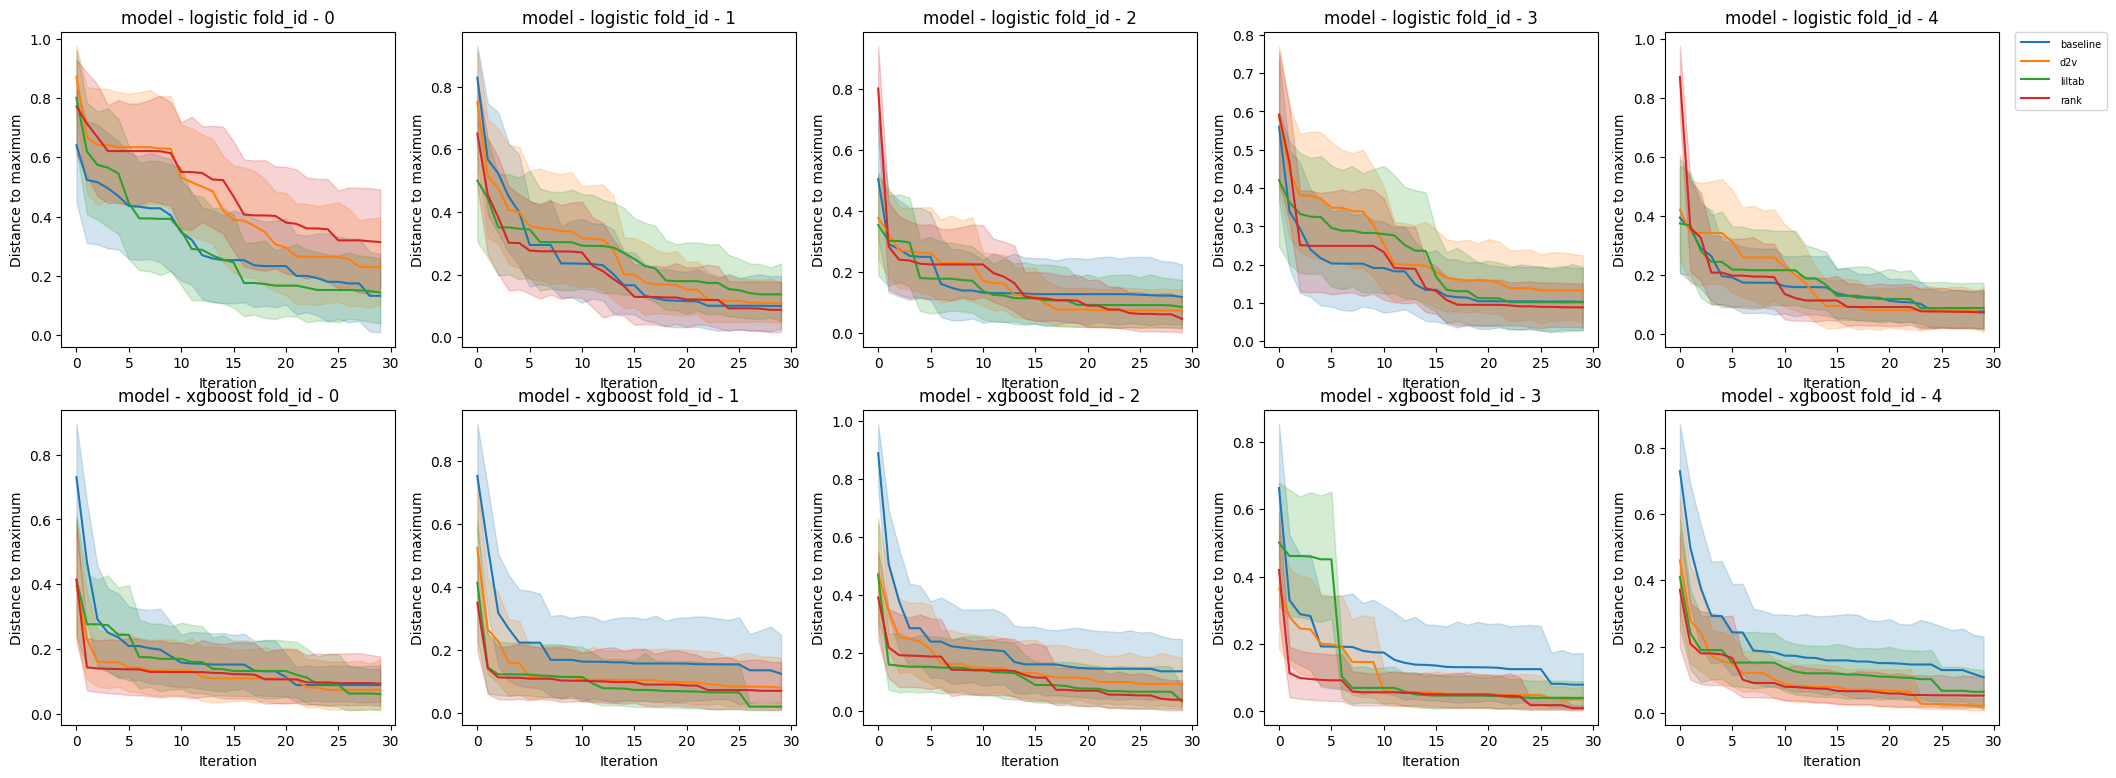

In [154]:
models = ["logistic", "xgboost"]
fold_ids = list(range(5))

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(25, 9))

for i, model in enumerate(models):
    for j, fold in enumerate(fold_ids):
        p = sns.lineplot(
            df_with_min_max[
                (df_with_min_max["model"] == model) & (df_with_min_max["fold"] == fold)
            ].sort_values("method"),
            x="no",
            y="max_minus_score",
            hue="method",
            ax=ax[i][j],
        )
        p.set_ylabel("Distance to maximum")
        p.set_xlabel("Iteration")
        p.set_title(f"model - {model} fold_id - {fold}")
        if i == 0 and j == len(fold_ids) - 1:
            p.legend(loc=(1.05, 0.75))
            plt.setp(p.get_legend().get_title(), fontsize=7)
            plt.setp(p.get_legend().get_texts(), fontsize=7)
        else:
            p.legend([], [], frameon=False)

In [ ]:
plot_data = df_with_min_max.pivot_table(
    index=["name", "no"], columns="method", values="max_minus_score"
).reset_index(drop=False)
plot_data["d2v_minus_rank_max_diff"] = plot_data["d2v"] - plot_data["rank"]

<Axes: xlabel='no', ylabel='d2v_minus_rank_max_diff'>

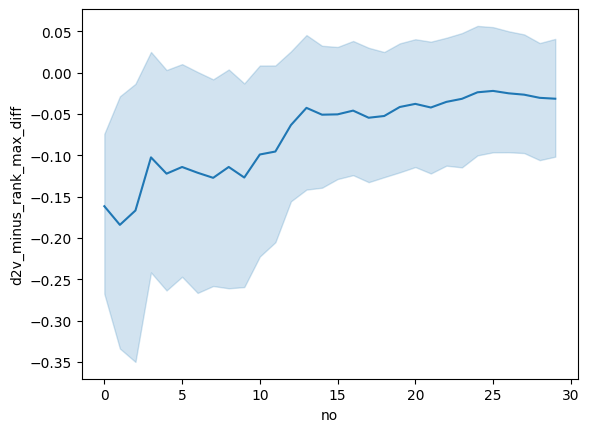

In [ ]:
sns.lineplot(plot_data, x="no", y="d2v_minus_rank_max_diff")

## Average gain against d2v and liltab

In [ ]:
df_pivot = pd.pivot_table(df, columns=["method"], index=["no", "name", "model"], values=["score"])
df_pivot.columns = df_pivot.columns.get_level_values(1)
df_pivot = df_pivot.reset_index()

df_pivot["gain_over_d2v"] = df_pivot["liltab"] - df_pivot["d2v"]
df_pivot["gain_over_rank"] = df_pivot["liltab"] - df_pivot["rank"]
df_pivot["gain_over_baseline"] = df_pivot["liltab"] - df_pivot["baseline"]
df_pivot["d2v_over_rank"] = df_pivot["d2v"] - df_pivot["rank"]
df_pivot["d2v_over_baseline"] = df_pivot["d2v"] - df_pivot["baseline"]

df_pivot = df_pivot[df_pivot["model"] == "logistic"]

df_pivot["technical"] = 0

Text(0.5, 1.0, 'Avg roc auc gain of d2v over rank.')

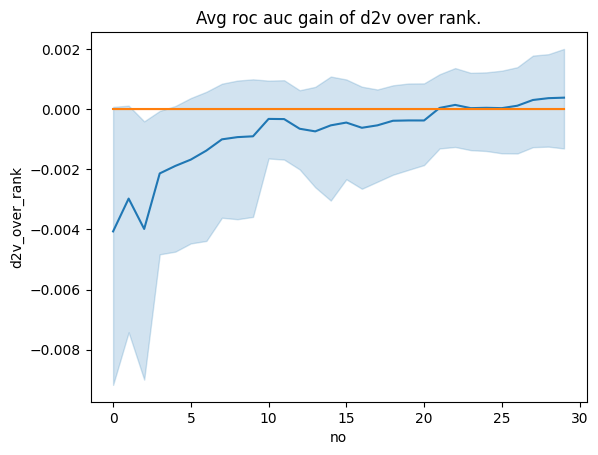

In [ ]:
sns.lineplot(df_pivot, x="no", y="d2v_over_rank")
sns.lineplot(df_pivot, x='no', y='technical').set_title("Avg roc auc gain of d2v over rank.")

<Axes: xlabel='no', ylabel='d2v_over_baseline'>

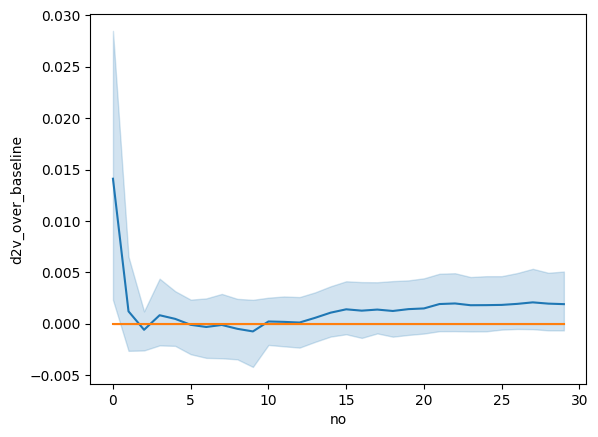

In [ ]:
sns.lineplot(df_pivot, x="no", y="d2v_over_baseline")
sns.lineplot(df_pivot, x='no', y='technical')

<Axes: xlabel='no', ylabel='gain_over_rank'>

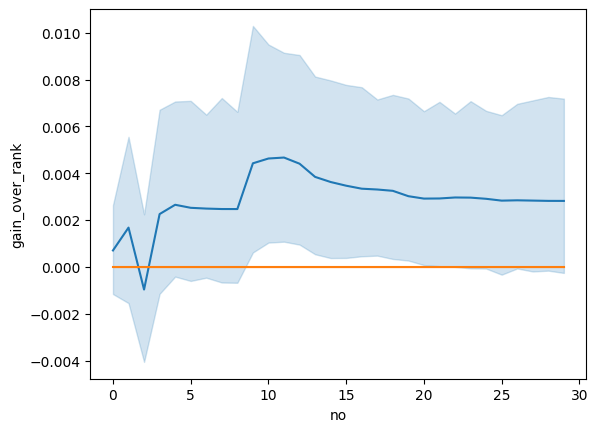

In [ ]:
sns.lineplot(df_pivot, x="no", y="gain_over_rank")
sns.lineplot(df_pivot, x="no", y="technical")